EDA of new simulation to validate expected relationships given new simulation changes

# Setup

In [ ]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# AFM imports
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

from pyafm.util import invlogit
from pyafm.custom_logistic import CustomLogistic

In [12]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [13]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
db_params['port'] = 27018
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-0d12067d-f91a-4a6a-9de8-6f9b23b02d13
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': 27018, 'name': 'motivsim', 'user': '', 'pswd': ''}


In [14]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, steps, has 65579 documents
INFO:log_db.mongo:collection name, problems, has 15695 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, kcs, has 562 documents
INFO:log_db.mongo:collection name, students, has 80 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, simbatches, has 4 documents
INFO:log_db.mongo:collection name, tutor_events, has 245730 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, sessions, has 1600 documents
INFO:log_db.mongo:collection name, decisions, has 272315 documents
INFO:log_db.mongo:collection name, actions, has 272315 documents
INFO:log_db.mongo:collection name, sections, has 79 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 80 documents


In [15]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Clearing database before starting new simulation


# 1. Simulating learners

In [16]:
num_students = 100
num_sessions = 10

In [17]:
sim_helper = SimHelper(db)

In [18]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
#     mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [19]:
new_curric = None
new_domain = None

In [20]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [21]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Simple Diligent students

In [22]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    ability = random.triangular(-1,1)
    #logger.info(f"Generating student with ability: {ability}")
    return {'ability': ability}

def get_dec_params():
    return {}

In [23]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 616 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, 387bccfa-51c6-4337-8958-97845391d6ba, to db
INFO:log_db.curriculum_mapper:Writing 17458 problem to db
INFO:log_db.curriculum_mapper:Writing 72909 steps to db
INFO:analytics.session:Persisting 20 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #2
INFO:analytics.session:Simulating student #4
INFO:analytics.session:Simulating student #6
INFO:analytics.session:Simulating student #8
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #12
INFO:analytics.session:Simulating student #14
INFO:analytics.session:Simulating student #16
INFO:analytics.session:Simulating student #18
INFO:analytics.session:Inserting 20 simulated students to db
INFO:anal

## Self Efficacy Diligent students

In [24]:
sim_batch_desc = "Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se}}

In [25]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 20 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #2
INFO:analytics.session:Simulating student #4
INFO:analytics.session:Simulating student #6
INFO:analytics.session:Simulating student #8
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #12
INFO:analytics.session:Simulating student #14
INFO:analytics.session:Simulating student #16
INFO:analytics.session:Simulating student #18
INFO:analytics.session:Inserting 20 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 20 in batch with id: 8a1a649b-4790-4774-a9ac-5f93a9876165


## Intrinsic Interest Diligent students

In [26]:
sim_batch_desc = "Intrinsic Interest students"
cog_mod = BiasSkillCognition
dec_mod = MathInterestDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {'attr': {'interest': np.random.normal(0,1)}}

In [27]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 20 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #2
INFO:analytics.session:Simulating student #4
INFO:analytics.session:Simulating student #6
INFO:analytics.session:Simulating student #8
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #12
INFO:analytics.session:Simulating student #14
INFO:analytics.session:Simulating student #16
INFO:analytics.session:Simulating student #18
INFO:analytics.session:Inserting 20 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 20 in batch with id: cc38b859-ba0a-4159-b691-4ec03c166e86


## Self-eff/Interest Diligent students

In [28]:
sim_batch_desc = "Combo students"
cog_mod = BiasSkillCognition
dec_mod = MathIntSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se, 'interest': np.random.normal(0,1)}}

In [29]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 20 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #2
INFO:analytics.session:Simulating student #4
INFO:analytics.session:Simulating student #6
INFO:analytics.session:Simulating student #8
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #12
INFO:analytics.session:Simulating student #14
INFO:analytics.session:Simulating student #16
INFO:analytics.session:Simulating student #18
INFO:analytics.session:Inserting 20 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 20 in batch with id: 87f0d98f-2fd2-4877-8b8b-88f5127e44fc


# Validation EDA

## Setup

In [30]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [31]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [32]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [33]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [34]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [35]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)
#     logger.info(f"Merged actions and decisions with tx: {tx['stu_id'].unique().shape}")

    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
#     logger.info("Completed step rollup {steps['stu_id'].unique().shape}")
    

    # Calculate student non-diligent stats
#     logger.info(f"Number of students in tx: {tx['stu_id'].unique().shape}")
    detect_offtask = calc.calc_detected_offtask(tx)
#     logger.info(f"Detect offtask: {detect_offtask.shape}")
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)
#     logger.info("Calculated off-task and diligence metrics")

    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)
#     logger.info(f"Over Practice: {over_prac.shape}")
#     logger.info("Calculated kc practice stats")

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()
#     logger.info("exp_work_rate: {exp_work_rate.shape}")
#     logger.info("Calculated work rate stats")

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()
    #stu_level_hints.columns = [f"{col}-hints_used" for col in stu_level_hints.columns.tolist()]

    # Fit line for each student tendency to request hint
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()
#     logger.info("Calculated detector error counts")

#     total_stats = {}
#     total_stats['ot_tp'] = np.sum(tx['offtask_tp']) / tx.shape[0]
#     total_stats['ot_fp'] = np.sum(tx['offtask_fp']) / tx.shape[0]
#     total_stats['ot_tn'] = np.sum(tx['offtask_tn']) / tx.shape[0]
#     total_stats['ot_fn'] = np.sum(tx['offtask_fn']) / tx.shape[0]



#     total_stats['g_tp'] = np.sum(tx['guess_tp']) / tx.shape[0]
#     total_stats['g_fp'] = np.sum(tx['guess_fp']) / tx.shape[0]
#     total_stats['g_tn'] = np.sum(tx['guess_tn']) / tx.shape[0]
#     total_stats['g_fn'] = np.sum(tx['guess_fn']) / tx.shape[0]
#     det_err[desc] = total_stats

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac, 
                         over_prac, work_rate, exp_work_rate, ot_err, g_err], axis=1)
#     logger.info(f"Merged stats: {stats.shape}")
    return stats


In [36]:
def afm_stu_intercept(kcs, opps, actuals, stu, student_label, item_label, nfolds=3,
        seed=None):
    """
    Executes AFM on the provided data and returns model fits and parameter
    estimates
    """
    sv = DictVectorizer()
    qv = DictVectorizer()
    ov = DictVectorizer()

    S = sv.fit_transform(stu)
    Q = qv.fit_transform(kcs)
    O = ov.fit_transform(opps)

    X = hstack((S, Q, O))
    y = np.array(actuals)

    l2 = [1.0 for i in range(S.shape[1])]
    l2 += [0.0 for i in range(Q.shape[1])]
    l2 += [0.0 for i in range(O.shape[1])]

    bounds = [(None, None) for i in range(S.shape[1])]
    bounds += [(None, None) for i in range(Q.shape[1])]
    bounds += [(0, None) for i in range(O.shape[1])]

    X = X.toarray()
    X2 = Q.toarray()

    model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
    model.fit(X, y)

    coef_s = model.coef_[0:S.shape[1]]
    coef_s = [[k, v, invlogit(v)]
              for k, v in sv.inverse_transform([coef_s])[0].items()]

    return coef_s

In [37]:
def get_afm_steps(sids):
    tx = get_tx(sids)
    
    # Rollup steps
    #Step outcome
    step_outcomes = tx.sort_values('time').groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['outcome'].first()
    # Get time stamp for last tx
    time = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])
    steps = pd.concat([step_outcomes, time], axis=1)
    # Get kc
    steps = pd.merge(steps, tx.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    return steps

def run_afm(steps):
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    
    nfolds = 3
    seed = None
#     scores, kc_vals, coef_s = afm(kcs, opps, y, stu,
#                                   student_label, item_label, nfolds, seed)
    coef_s = afm_stu_intercept(kcs, opps, y, stu,
                                  student_label, item_label, nfolds, seed)
    stu_intercepts = pd.DataFrame(coef_s, columns=['stu_id', 'Intercept (logit)', 'Intercept (prob)'])
    stu_intercepts.index = stu_intercepts['stu_id']
    stu_intercepts.drop(columns=['stu_id'], inplace=True)
    return stu_intercepts

## Calculate Stats

In [38]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [39]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
               "Self-Efficacy students",
               "Intrinsic Interest students",
               "Combo students"
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: 6c5e37d6-b080-4373-82b3-249f1089f10a
desc: Simple diligent students
INFO:analytics.session:recovered 20 student ids for batch Simple diligent students
INFO:analytics.session:batch #1: 
ID: 8a1a649b-4790-4774-a9ac-5f93a9876165
desc: Self-Efficacy students
INFO:analytics.session:recovered 20 student ids for batch Self-Efficacy students
INFO:analytics.session:batch #2: 
ID: cc38b859-ba0a-4159-b691-4ec03c166e86
desc: Intrinsic Interest students
INFO:analytics.session:recovered 20 student ids for batch Intrinsic Interest students
INFO:analytics.session:batch #3: 
ID: 87f0d98f-2fd2-4877-8b8b-88f5127e44fc
desc: Combo students
INFO:analytics.session:recovered 20 student ids for batch Combo students


In [40]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")

batch_size = 10
for desc in batch_descs:


    sid = sids[desc][0]
    logger.info(f"EDA of {len(sid)} students for batch, {desc}")

    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, batch_size, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [calc.get_action_counts, sid, batch_size]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, batch_size]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


    args = [session_calc.calc_stu_session_stats, sid, batch_size]
    ses_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {ses_stats.shape}\tRuntime: {runtime} seconds")

    args = [calc_stats, sid, batch_size]
    dil_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated diligence stats: {dil_stats.shape}\tRuntime: {runtime} seconds")
    
    args = [get_afm_steps, sid, batch_size]
    afm_steps, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated Step rollup for afm: {afm_steps.shape}\tRuntime: {runtime} seconds")

#    stu_afm = run_afm(afm_steps)
    stu_afm, runtime = batch_calc.time_calc(run_afm, [afm_steps])
    logger.info(f"Calculated afm intercepts: {stu_afm.shape}\tRuntime: {runtime} seconds")


    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
                                 dil_stats, stu_afm], axis=1)


#     stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
#                                  dil_stats], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 20 students for batch, Simple diligent students
INFO:analytics.session:Calculating for student set:	Simple diligent students
INFO:analytics.session:Calculated student params: (20, 20)	Runtime: 0.115476 seconds
INFO:analytics.session:Calculated student action stats: (20, 13)	Runtime: 2.520789 seconds
INFO:analytics.session:Calculated student activity stats: (20, 9)	Runtime: 2.135324 seconds
INFO:analytics.session:Calculated student activity stats: (20, 5)	Runtime: 0.43891 seconds
INFO:analytics.session:Calculated diligence stats: (20, 20)	Runtime: 32.384547 seconds
INFO:analytics.session:Calculated Step rollup for afm: (30732, 9)	Runtime: 11.64332 seconds
INFO:analytics.session:Calculated afm intercepts: (20, 2)	Runtime: 78.025736 seconds
INFO:analytics.session:Merged new stats together: (20, 67)
INFO:analytics.session:EDA of 20 students for batch, Self-Efficacy students
INFO:analytics.session:Calculating for stud

## Student Parameters EDA

INFO:analytics.session:Simple diligent students


['diligence', 'cog_ability', 'dec_self_eff']


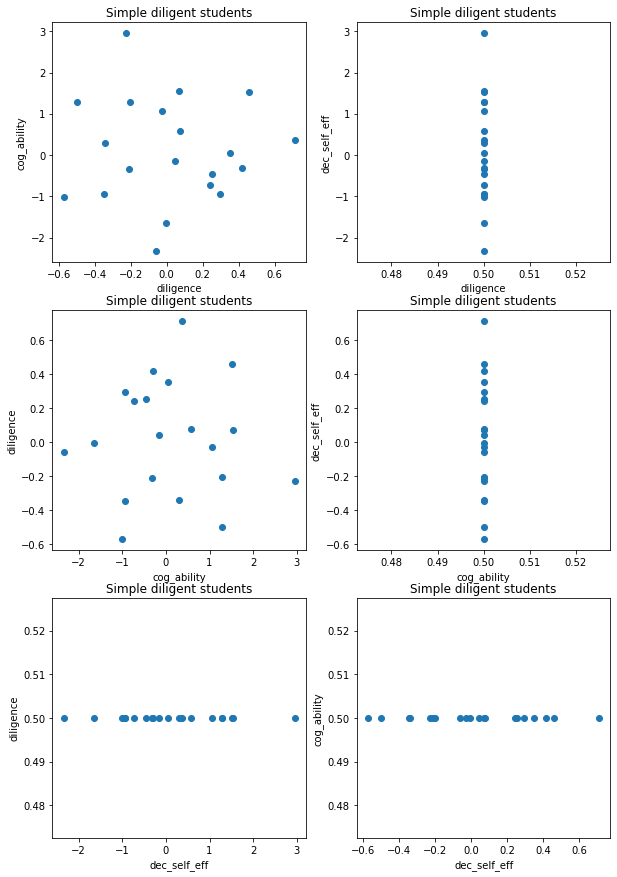

INFO:analytics.session:Self-Efficacy students


['diligence', 'cog_ability', 'dec_self_eff']


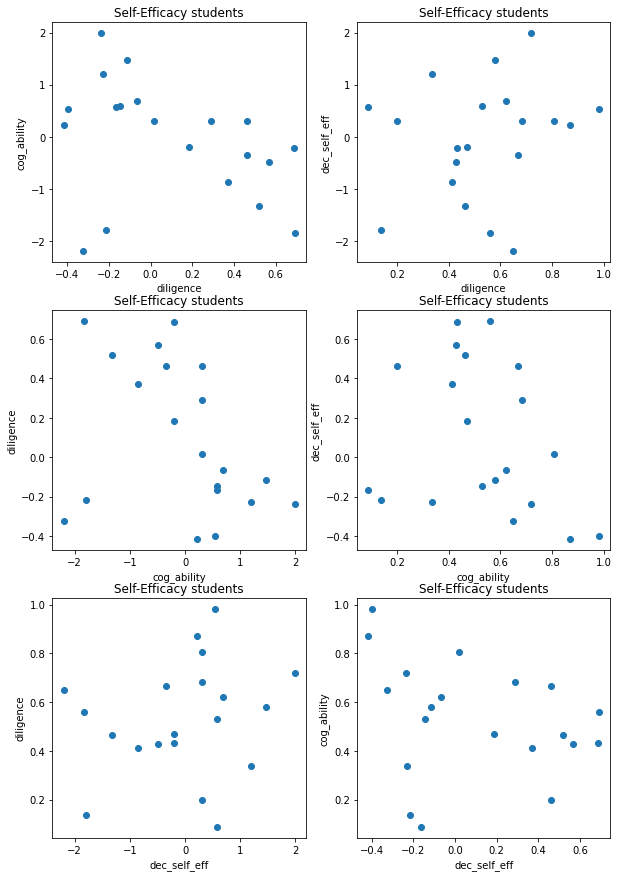

INFO:analytics.session:Intrinsic Interest students


['diligence', 'cog_ability', 'dec_self_eff', 'dec_interest']


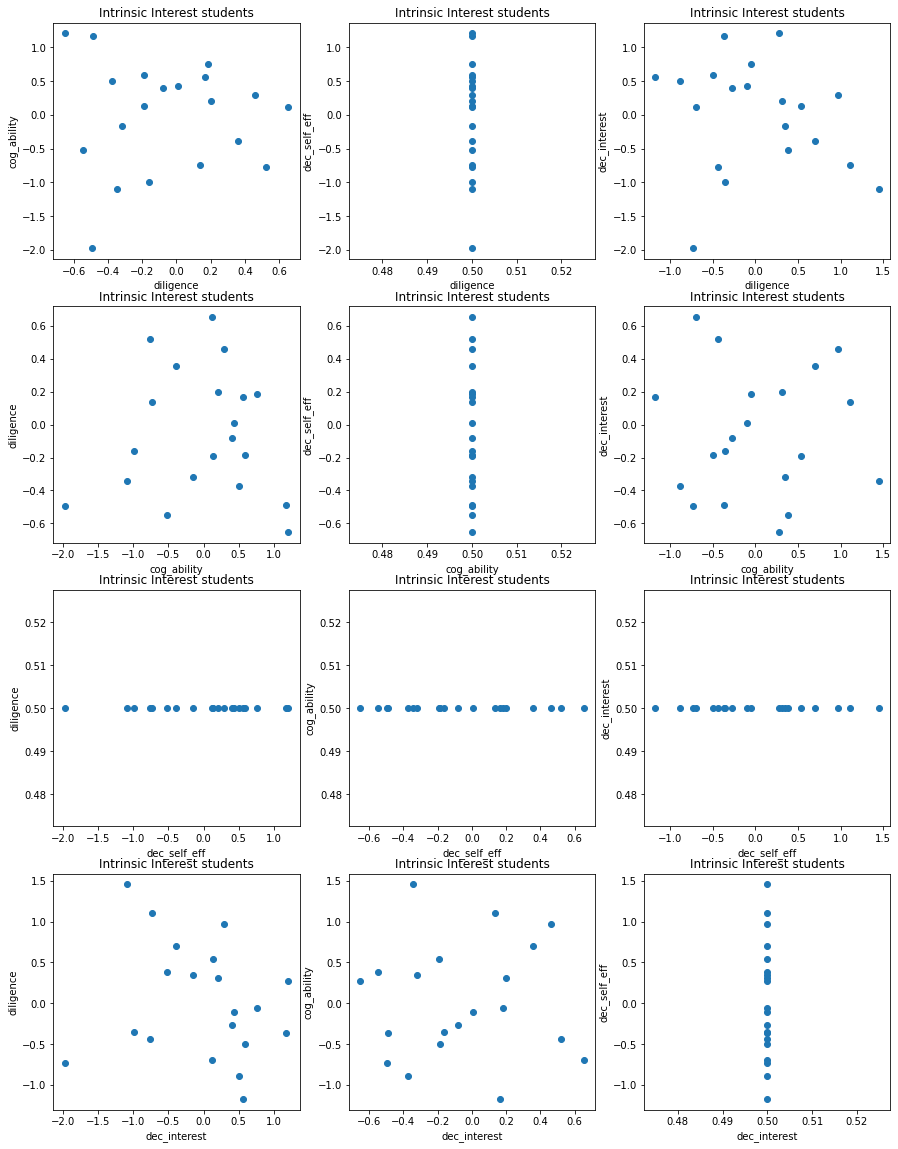

INFO:analytics.session:Combo students


['diligence', 'cog_ability', 'dec_self_eff', 'dec_interest']


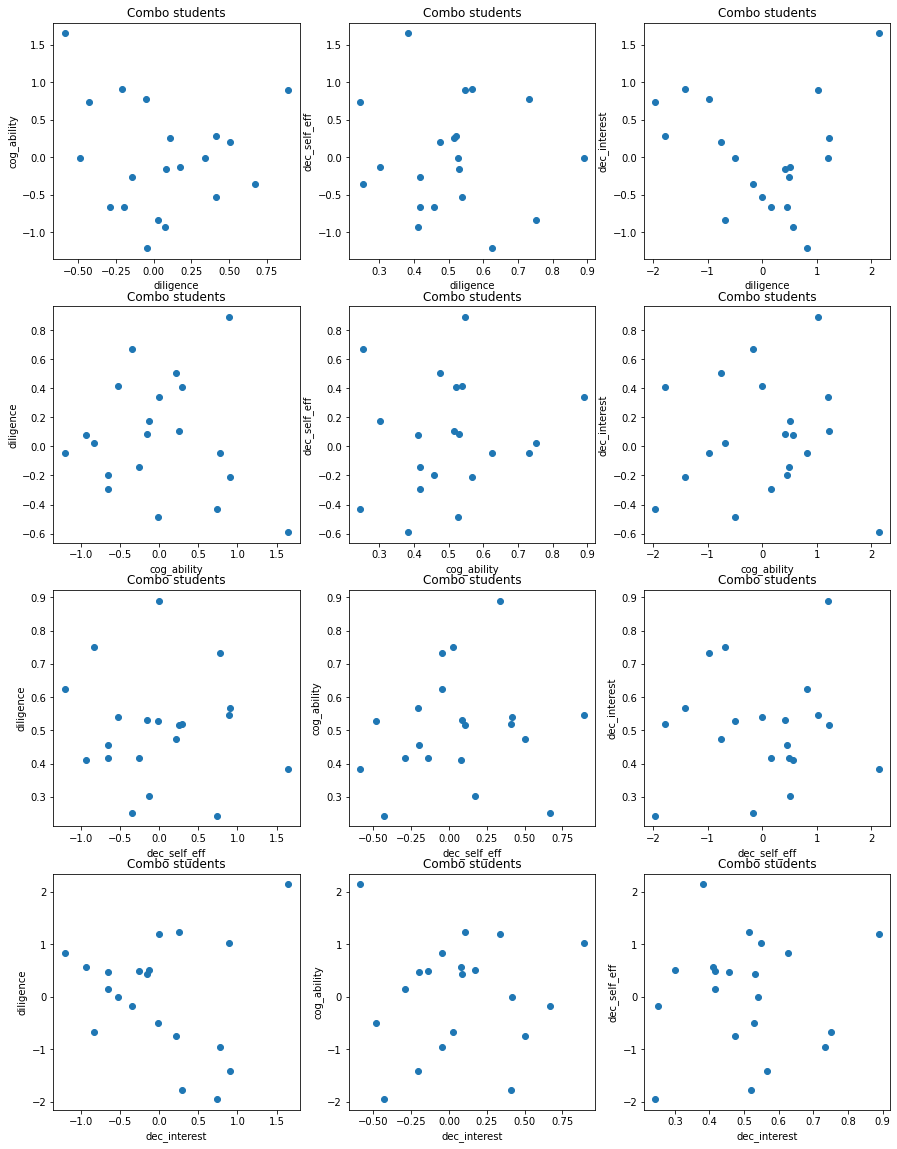

In [41]:


cols = ['diligence', 'cog_ability', 'dec_self_eff', 'dec_interest']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    i = 1
    avail_cols = [c for c in cols if c in sstats.columns.tolist()]
    print(avail_cols)
    l = len(avail_cols)
    plt.figure(figsize=(5*(l-1),5*(l)))
    logger.info(desc)
    for xcol in avail_cols:
        other_cols = [c for c in avail_cols if xcol != c]
        for ycol in other_cols:
            x = sstats[xcol]
            y = sstats[ycol]
            plt.subplot(len(avail_cols), len(other_cols), i)
            plt.scatter(y,x)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            plt.title(desc)    
            i += 1
    plt.show()
    

## Simulation Noise

### Session Opportunity

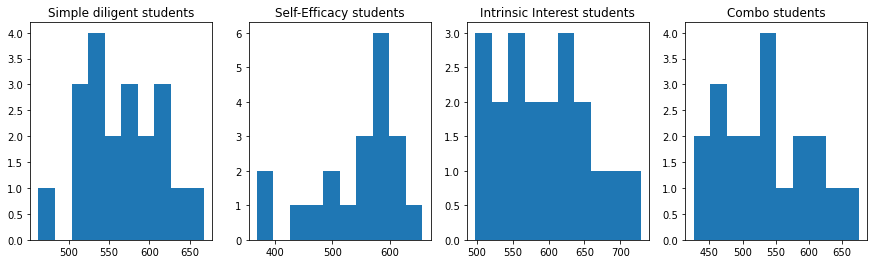

In [42]:
plt.figure(figsize=(15,4))
l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    col = 'total opportunity'
    plt.subplot(1,l, i+1)
    plt.hist(sstats['total opportunity'])
    plt.title(desc)    
plt.show()
    

### Detector error rates

In [43]:
plt.figure(figsize=(15,4))
l = len(batch_descs)
for i,desc in enumerate(batch_descs):
    logger.info(f"************** {desc} ******************")
    d = stu_stats[desc]
    cols = [col for col in d.columns.tolist() if "offtask_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Offtask Error Rates: \nTP: {dpct['offtask_tp']}\tFP: {dpct['offtask_fp']}\tTN: {dpct['offtask_tn']}\tFN: {dpct['offtask_fn']}")
    cols = [col for col in d.columns.tolist() if "guess_" in str(col)]
    dsum = d.loc[:,cols].apply(np.sum, axis=0)
    total = np.sum(dsum)
    dpct = dsum.apply(lambda x: x/total)
    logger.info(f"Guess Error Rates: \nTP: {dpct['guess_tp']}\tFP: {dpct['guess_fp']}\tTN: {dpct['guess_tn']}\tFN: {dpct['guess_fn']}")


INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Offtask Error Rates: 
TP: 0.01184612507014153	FP: 0.09960097262921629	TN: 0.8881944011472037	FN: 0.0003585011534384937
INFO:analytics.session:Guess Error Rates: 
TP: 0.0014017381553125877	FP: 0.0049995327539482295	TN: 0.9579167056038377	FN: 0.03490328006728343
INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Offtask Error Rates: 
TP: 0.01785339891944198	FP: 0.05276993790823321	TN: 0.9293766631723248	FN: 0.0
INFO:analytics.session:Guess Error Rates: 
TP: 0.002771734751430183	FP: 0.0009185400048344211	TN: 0.9509145113206027	FN: 0.04458947707678672
INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Offtask Error Rates: 
TP: 0.013860479752828597	FP: 0.09889716925805667	TN: 0.8871565275850725	FN: 8.582340404228233e-05
INFO:analytics.session:Guess Error Rates: 
TP: 0.001300724689

<Figure size 1080x288 with 0 Axes>

### Work Rate - Tutor Policy Overpractice

INFO:analytics.session:************** Simple diligent students ******************


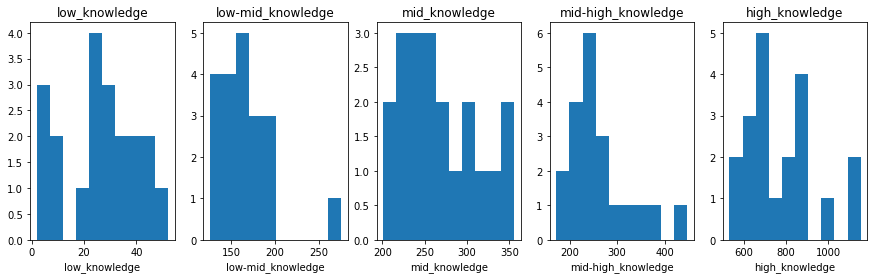

INFO:analytics.session:************** Self-Efficacy students ******************


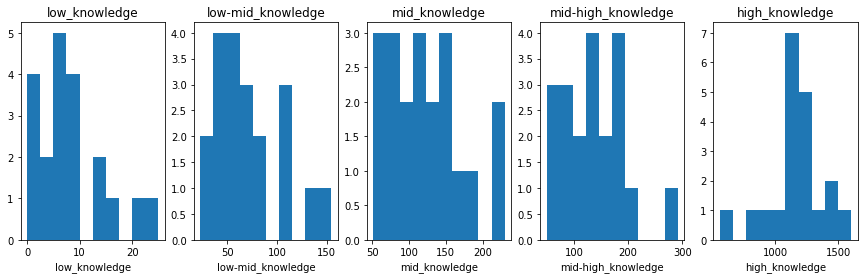

INFO:analytics.session:************** Intrinsic Interest students ******************


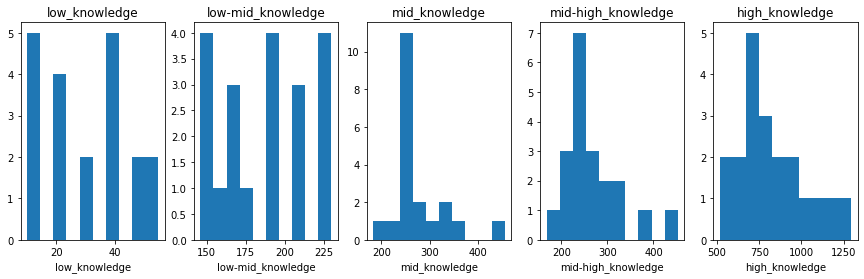

INFO:analytics.session:************** Combo students ******************


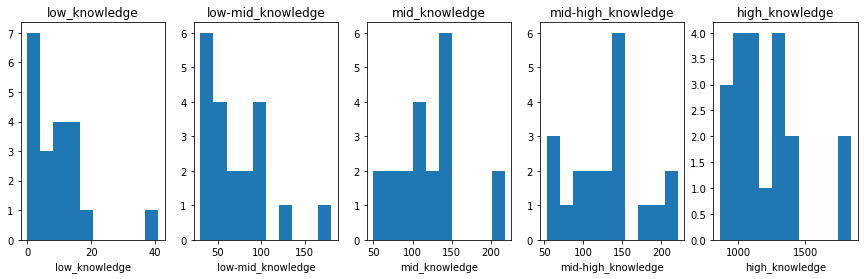

In [44]:

know_lvls = ['low_knowledge', 'low-mid_knowledge','mid_knowledge', 'mid-high_knowledge', 'high_knowledge']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(15,4))    
    for j, col in enumerate(know_lvls):
        plt.subplot(1,len(know_lvls), j+1)
        plt.hist(sstats[col])
        plt.xlabel(col)
        plt.title(col)

    plt.show()

## Diligence

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.1324936441681813	 pval = 0.5776356230920249
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.13370277277559883	 pval = 0.5741368213117846
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = 0.11085153961449931	 pval = 0.6417445771420422
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8303465742042475	 pval = 5.8688127346019154e-06
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.3557638896741555	 pval = 0.12369396498338855


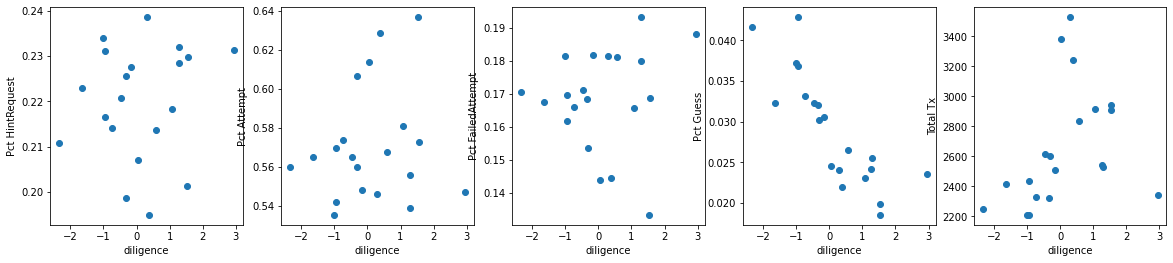

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.41637195588719417	 pval = 0.06783121887998123
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = -0.11846901682019155	 pval = 0.6188693902847081
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = -0.14118018168702434	 pval = 0.5527065499776256
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.11383392968303888	 pval = 0.6327499882666608
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.2877633265875206	 pval = 0.21859136672670434


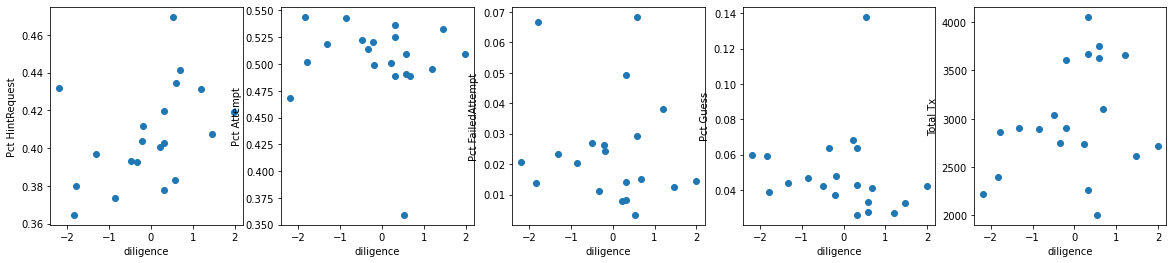

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.11344518861087521	 pval = 0.6339196170463963
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.12450535640434413	 pval = 0.600977671280599
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = 0.08944881178914843	 pval = 0.7076434182806433
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8800737514783532	 pval = 3.129180909872059e-07
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.3917101292386613	 pval = 0.08763308227111795


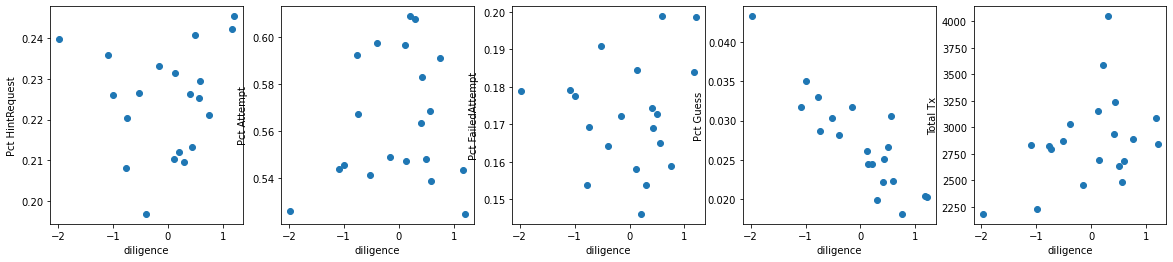

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with diligence: 
R = 0.21734814401067423	 pval = 0.3573142507866314
INFO:analytics.session:Pct Attempt Correlation with diligence: 
R = 0.1164102104934024	 pval = 0.6250198839974813
INFO:analytics.session:Pct FailedAttempt Correlation with diligence: 
R = 0.16786131069754634	 pval = 0.4793142522375389
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.44031420583322944	 pval = 0.052022660181151134
INFO:analytics.session:Total Tx Correlation with diligence: 
R = 0.35622409762908364	 pval = 0.12317434816314439


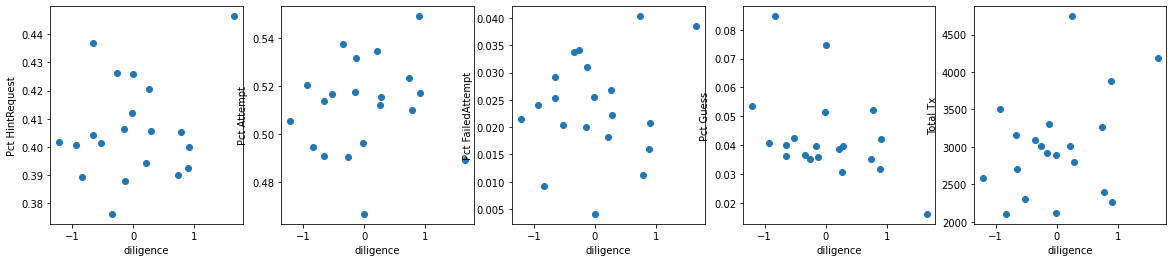

In [45]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Total Time

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.5295811834676482	 pval = 0.01633213003373904
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.6353673052235778	 pval = 0.002609454108341519
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.915729074575133	 pval = 1.4945845898394587e-08
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.1933381382905169	 pval = 0.41409428292386674
INFO:analytics.session:session length Correlation with diligence: 
R = 0.5823162044569326	 pval = 0.007060415571291614


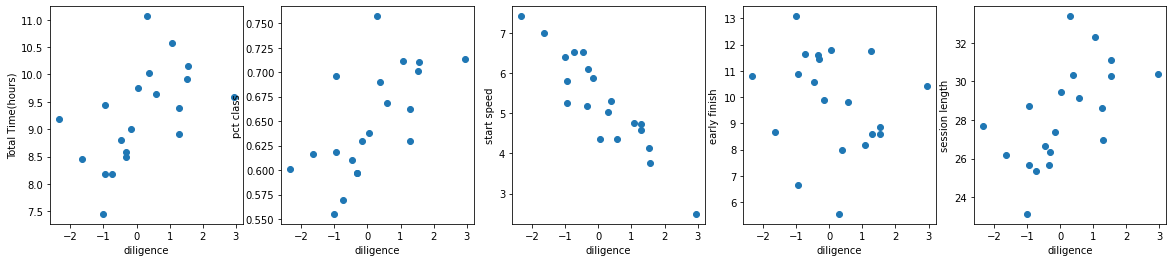

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.20390450220780415	 pval = 0.38853097458624053
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.21330259607956906	 pval = 0.3665523091890334
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.9084108353004796	 pval = 3.077096669342588e-08
INFO:analytics.session:early finish Correlation with diligence: 
R = 0.09710944024725651	 pval = 0.6837963901408021
INFO:analytics.session:session length Correlation with diligence: 
R = 0.1924479859983264	 pval = 0.4162884641191645


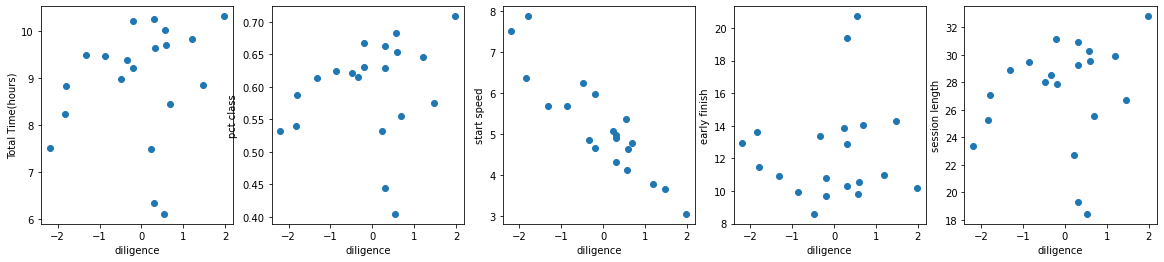

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.32475150326502955	 pval = 0.16240598876276988
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.36907622942405716	 pval = 0.10928498349578784
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.4337264895685255	 pval = 0.05605877162989873
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.1513217699170404	 pval = 0.5242283914885238
INFO:analytics.session:session length Correlation with diligence: 
R = 0.29725195680651584	 pval = 0.20310324062671709


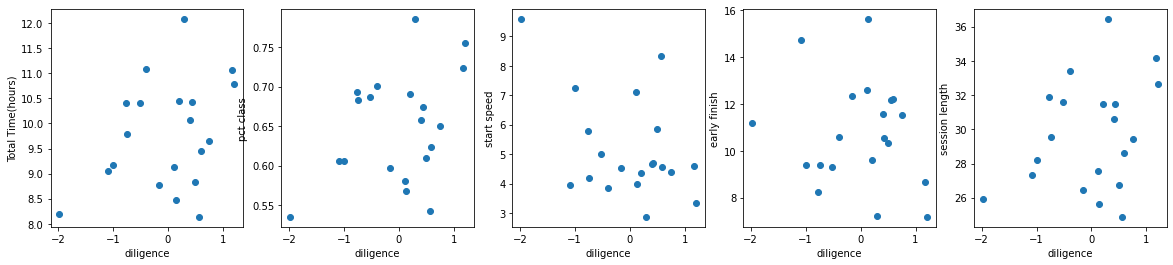

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.36934394804622267	 pval = 0.10900824805522537
INFO:analytics.session:pct class Correlation with diligence: 
R = 0.3963952904888963	 pval = 0.08357803184723128
INFO:analytics.session:start speed Correlation with diligence: 
R = -0.21137853177701987	 pval = 0.37099321613446096
INFO:analytics.session:early finish Correlation with diligence: 
R = -0.24250506683082934	 pval = 0.3029324884925277
INFO:analytics.session:session length Correlation with diligence: 
R = 0.3708068007821978	 pval = 0.10750505971440823


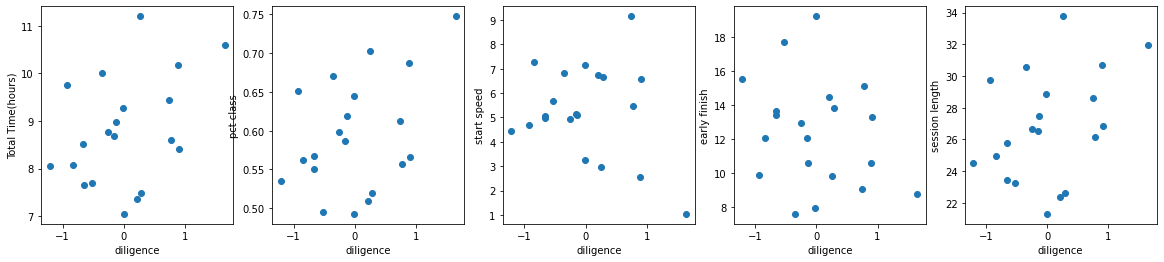

In [46]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.5156293496171581	 pval = 0.019964822299250694
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.6767511351235538	 pval = 0.0010494621826959176
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8303465742042475	 pval = 5.8688127346019154e-06
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.03434699841557748	 pval = 0.8856933985786272
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.49809717106959234	 pval = 0.02541201407755131


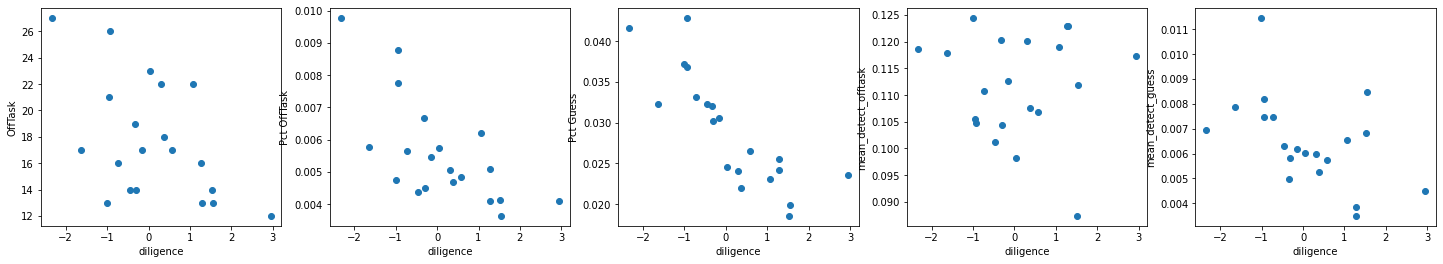

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.09471786483380276	 pval = 0.6912115437145353
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.15646575197764995	 pval = 0.510051938501752
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.11383392968303888	 pval = 0.6327499882666608
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.26104360139387783	 pval = 0.2662814311426934
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.029821759618897006	 pval = 0.9006766069901257


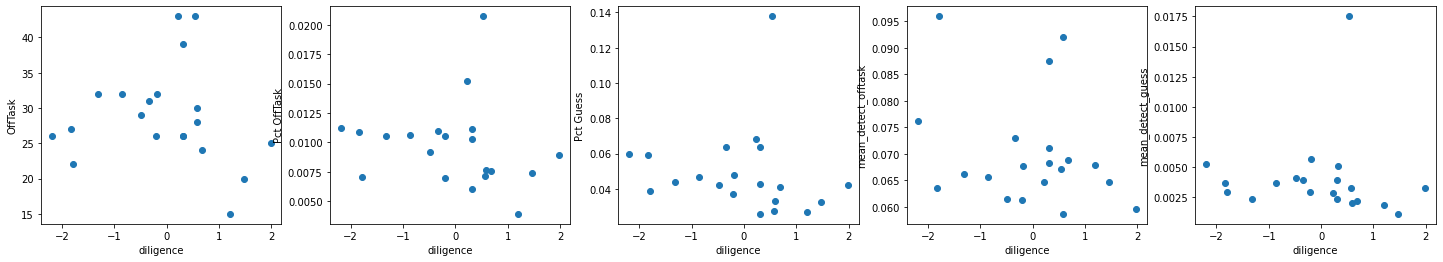

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.0679184502643133	 pval = 0.7760186175767501
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.2784814750554829	 pval = 0.2344729170413848
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.8800737514783532	 pval = 3.129180909872059e-07
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.05241763929818807	 pval = 0.8262800694432177
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.501333971613442	 pval = 0.024326875102082854


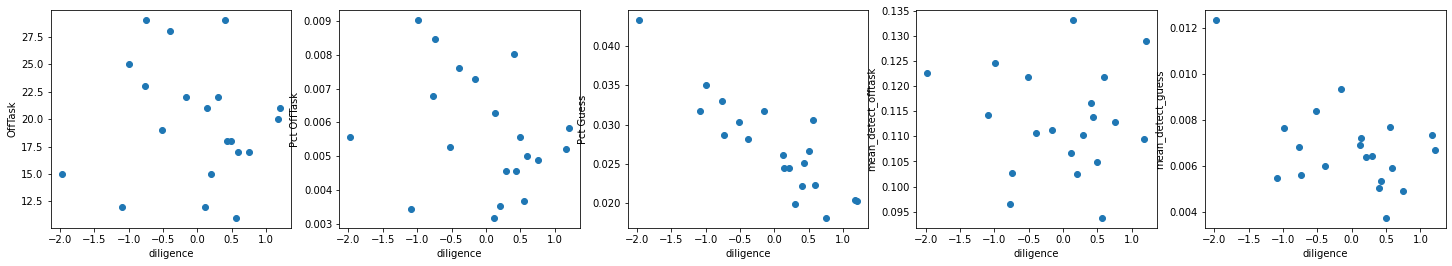

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:OffTask Correlation with diligence: 
R = -0.08111890000668745	 pval = 0.7338739608422725
INFO:analytics.session:Pct OffTask Correlation with diligence: 
R = -0.1691517885348664	 pval = 0.47589274341525345
INFO:analytics.session:Pct Guess Correlation with diligence: 
R = -0.44031420583322944	 pval = 0.052022660181151134
INFO:analytics.session:mean_detect_offtask Correlation with diligence: 
R = -0.043688442196806565	 pval = 0.8548868212347105
INFO:analytics.session:mean_detect_guess Correlation with diligence: 
R = -0.22029667510071976	 pval = 0.3506665093082618


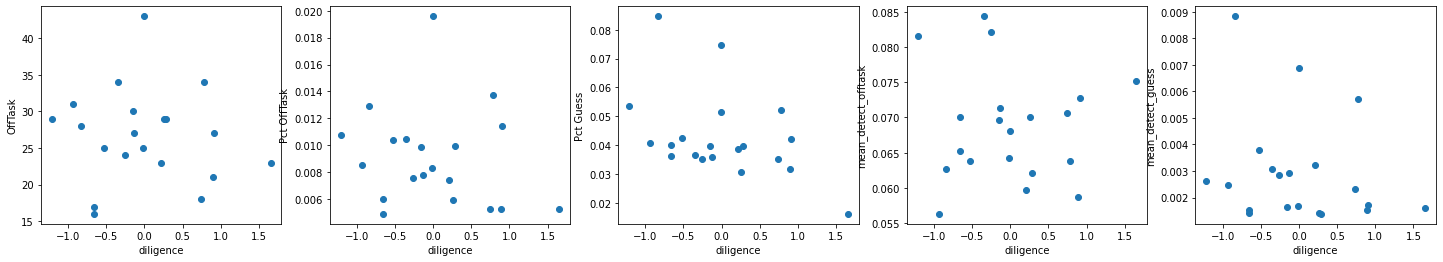

In [47]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(25,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Time-on-task

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.5295811834676482	 pval = 0.01633213003373904
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.44468450325597264	 pval = 0.049470175698279106
INFO:analytics.session:time_off_task Correlation with diligence: 
R = 0.11629720129476243	 pval = 0.6253581852149123


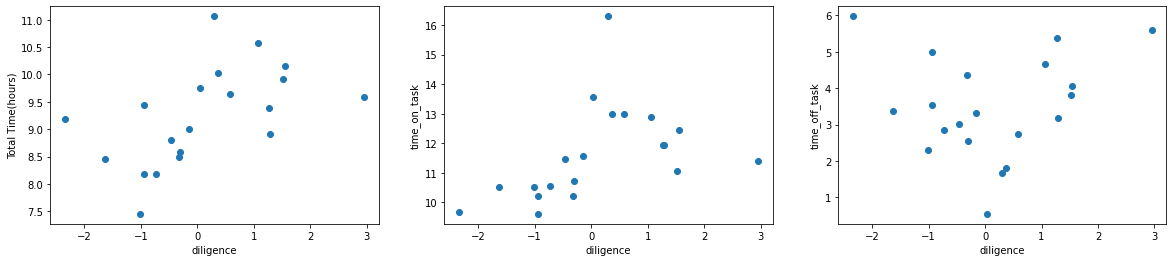

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.20390450220780415	 pval = 0.38853097458624053
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.23214052369523236	 pval = 0.3246936725725463
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.18857232317684447	 pval = 0.4259144997586681


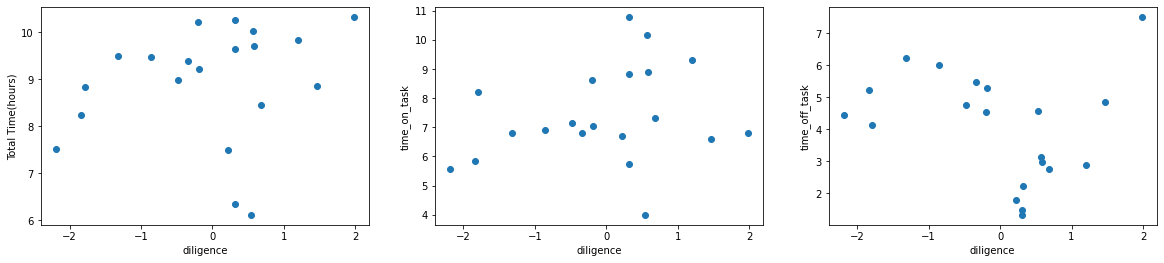

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.32475150326502955	 pval = 0.16240598876276988
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.437738264769477	 pval = 0.05357354354186434
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.19431975320404907	 pval = 0.4116819180473663


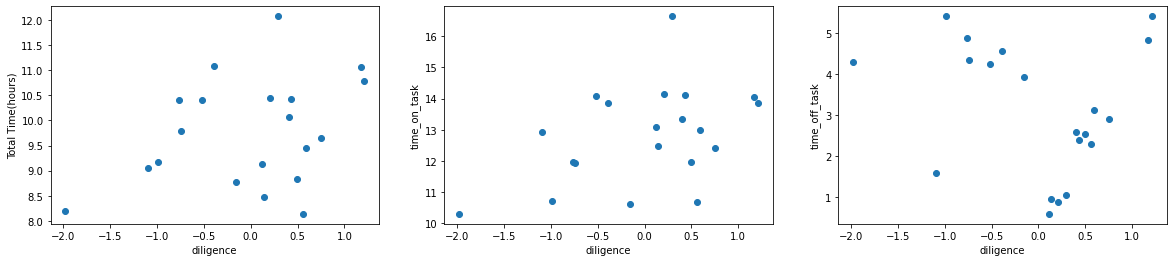

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with diligence: 
R = 0.36934394804622267	 pval = 0.10900824805522537
INFO:analytics.session:time_on_task Correlation with diligence: 
R = 0.3939982758183754	 pval = 0.08563495390892316
INFO:analytics.session:time_off_task Correlation with diligence: 
R = -0.221373437512001	 pval = 0.3482568341932388


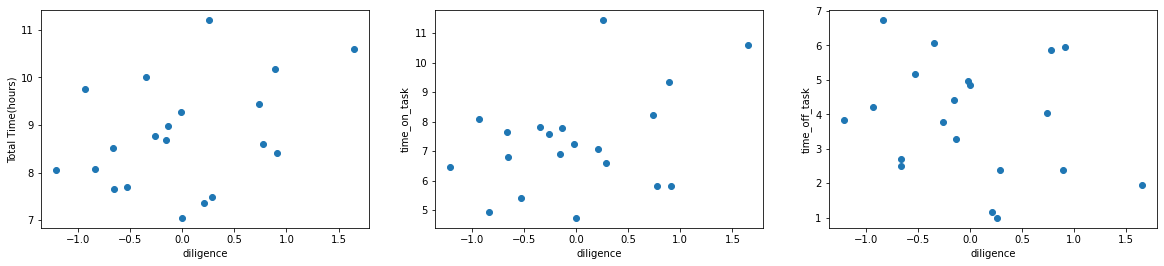

In [48]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = -0.02913244312584439	 pval = 0.9029619210581961
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.05733933447108257	 pval = 0.8102411100907101
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.2153295078536635	 pval = 0.3619069542033483
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.40626211916204974	 pval = 0.07549434552713861
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.264919797032701	 pval = 0.2589875942042433


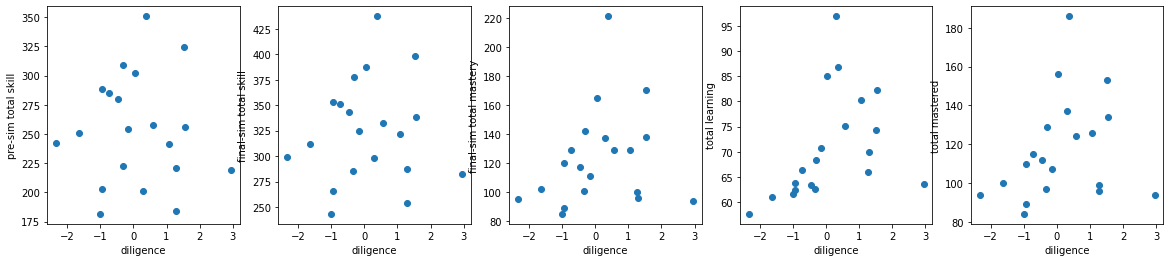

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = -0.39023022595581697	 pval = 0.0889435702404707
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = -0.34283822714067175	 pval = 0.13893323358087117
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = -0.1505023092043868	 pval = 0.5265036674020108
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.10756039980214001	 pval = 0.651726338939419
INFO:analytics.session:total mastered Correlation with diligence: 
R = -0.02556875771213881	 pval = 0.9147880680556508


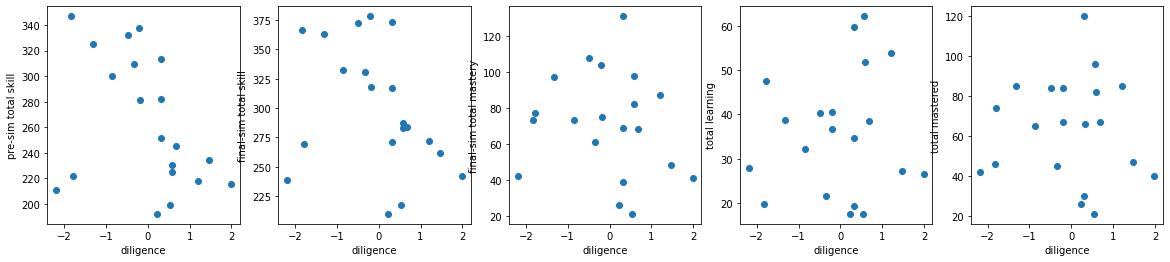

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = 0.0201499653457642	 pval = 0.9328027087190968
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = 0.11897397766754053	 pval = 0.6173645636719043
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.2693109547017952	 pval = 0.25087908164882466
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.4876694001751492	 pval = 0.02916999409442823
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.29893857145014924	 pval = 0.2004287465532873


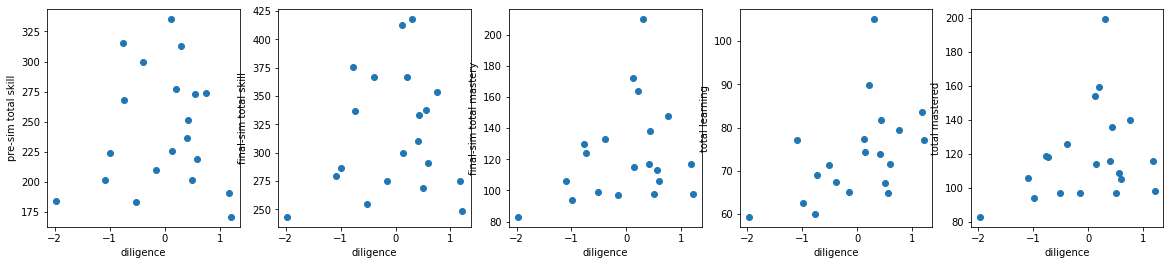

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with diligence: 
R = -0.12027664775242665	 pval = 0.6134892788647586
INFO:analytics.session:final-sim total skill Correlation with diligence: 
R = -0.04492140937787901	 pval = 0.8508347971480208
INFO:analytics.session:final-sim total mastery Correlation with diligence: 
R = 0.23798355428896334	 pval = 0.31231415558589504
INFO:analytics.session:total learning Correlation with diligence: 
R = 0.30608287021600916	 pval = 0.18936086343724998
INFO:analytics.session:total mastered Correlation with diligence: 
R = 0.235547269619918	 pval = 0.3174408597623863


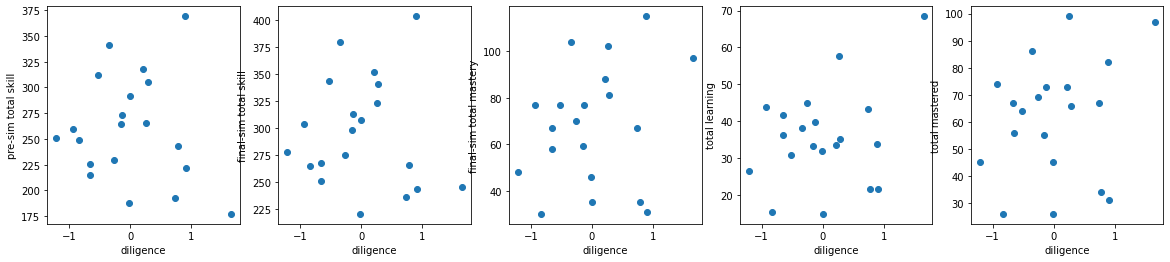

In [49]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'diligence'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Cog Ability

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9959205507370568	 pval = 2.9280286117041926e-20
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9781038267476511	 pval = 1.015003669338315e-13
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.8093675050464875	 pval = 1.544603716078807e-05
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.26343482885376435	 pval = 0.26176675739274663
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.7585220272600841	 pval = 0.00010608680575057204


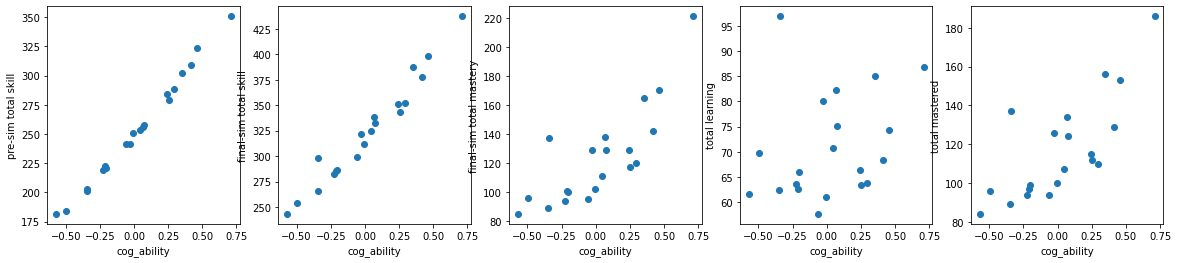

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9974860147254478	 pval = 3.7746525003612687e-22
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9641773988748796	 pval = 8.100813625027527e-12
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.6245065255001588	 pval = 0.0032454373334513025
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.0628441399739629	 pval = 0.7923880571053814
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.4042954881256178	 pval = 0.07705706159508888


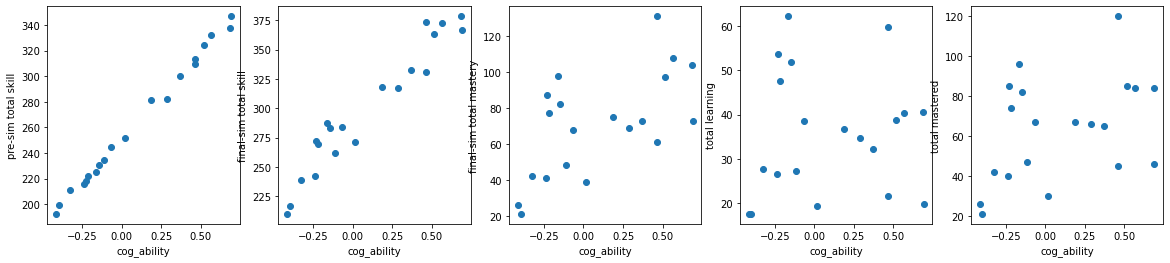

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9978622196548209	 pval = 8.787571727800372e-23
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9728123010164567	 pval = 6.984686752698048e-13
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.7814042358173023	 pval = 4.7431190719627564e-05
INFO:analytics.session:total learning Correlation with cog_ability: 
R = 0.21912934827894764	 pval = 0.3532897374070371
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.7291156923105485	 pval = 0.00026510849809987727


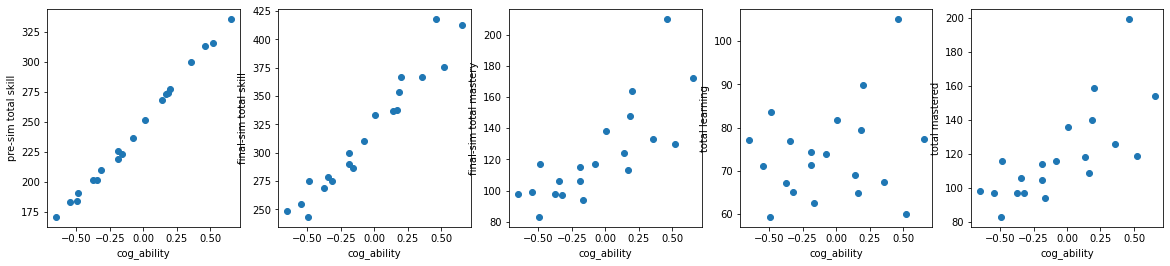

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with cog_ability: 
R = 0.9983234880807588	 pval = 9.876037344959262e-24
INFO:analytics.session:final-sim total skill Correlation with cog_ability: 
R = 0.9612762306948618	 pval = 1.6154951757971647e-11
INFO:analytics.session:final-sim total mastery Correlation with cog_ability: 
R = 0.4489092922133095	 pval = 0.04709494361019869
INFO:analytics.session:total learning Correlation with cog_ability: 
R = -0.27775837478653925	 pval = 0.2357406838275548
INFO:analytics.session:total mastered Correlation with cog_ability: 
R = 0.17948568759261757	 pval = 0.44894135068876256


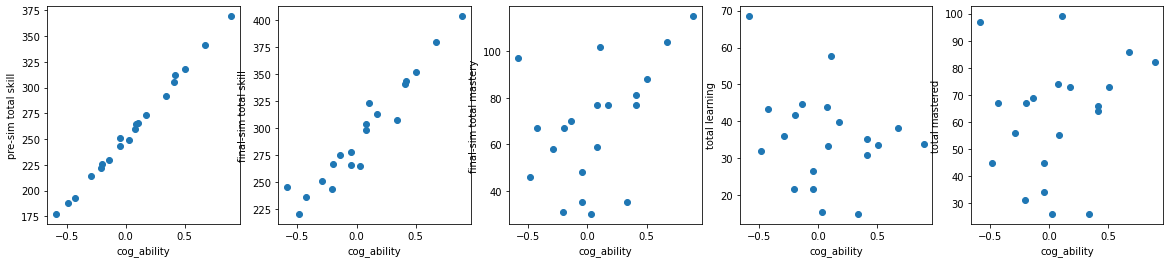

In [50]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.8773898617514483	 pval = 3.7802556045095313e-07
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.8769263874485178	 pval = 3.903953950106754e-07
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.8046214047642979	 pval = 1.8917937608054665e-05
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.2834256831999522	 pval = 0.22592287241491965
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.39600667666070316	 pval = 0.08390900182286949


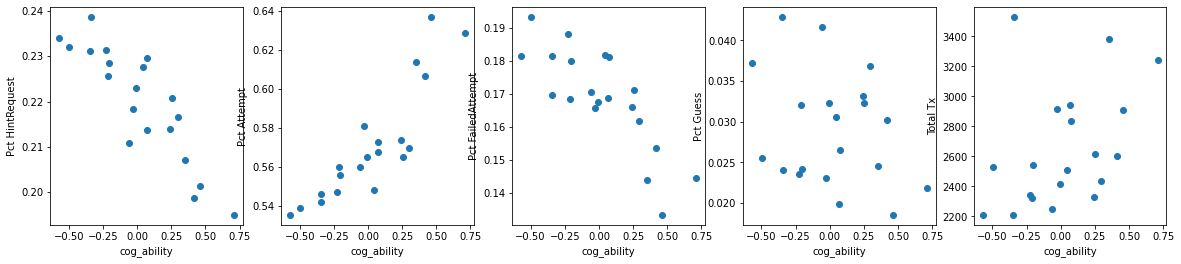

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.5978647786746822	 pval = 0.0053668110248652505
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.5968427814719084	 pval = 0.005466718583677379
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.0332896482064962	 pval = 0.8891911605568769
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.24926201464355088	 pval = 0.28923554533944296
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.24726175132315384	 pval = 0.293249873355238


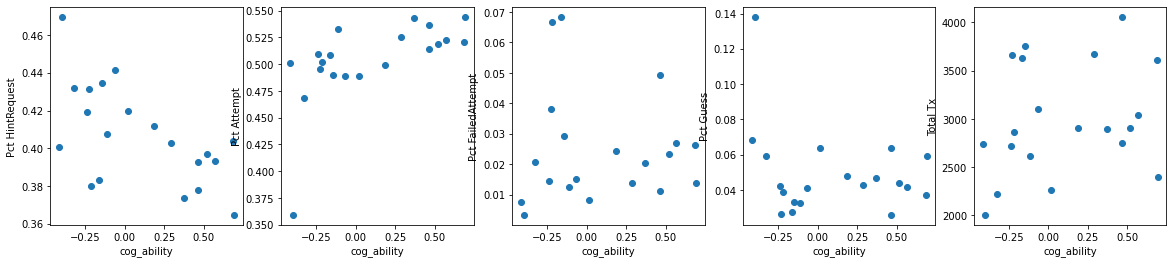

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.8824051356908303	 pval = 2.6456464620802504e-07
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.9076060205544398	 pval = 3.319165732962475e-08
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.8185439983362651	 pval = 1.0269039724203855e-05
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = -0.14047617982220362	 pval = 0.5547088232822386
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = 0.4772321341700495	 pval = 0.033355262703367444


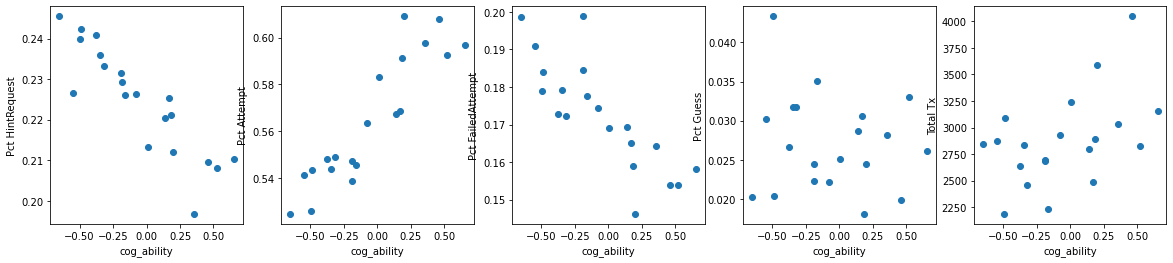

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with cog_ability: 
R = -0.4821124519373956	 pval = 0.03134355858326355
INFO:analytics.session:Pct Attempt Correlation with cog_ability: 
R = 0.5251862869275318	 pval = 0.01741402433807839
INFO:analytics.session:Pct FailedAttempt Correlation with cog_ability: 
R = -0.4204956432806228	 pval = 0.06487925611053824
INFO:analytics.session:Pct Guess Correlation with cog_ability: 
R = 0.07907433080159892	 pval = 0.7403571220441587
INFO:analytics.session:Total Tx Correlation with cog_ability: 
R = -0.016177243956565238	 pval = 0.9460304185615442


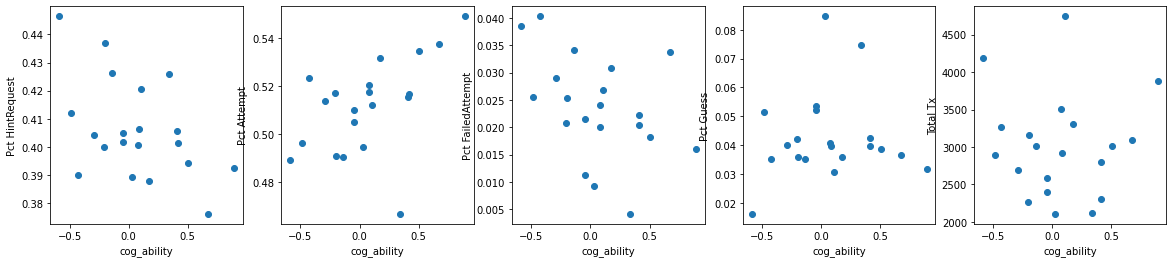

In [51]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Early Finish

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.0682559819826247	 pval = 0.7749328972007191
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.15020663223763947	 pval = 0.5273257599361656
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.11194188527527191	 pval = 0.6384505464784794
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.23466084905079268	 pval = 0.3193185958842431


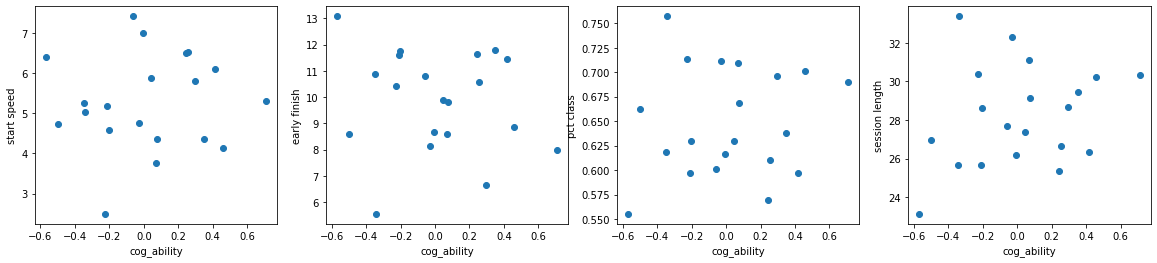

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = 0.11910536523167824	 pval = 0.6169732577025235
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.33919387985750765	 pval = 0.14345847186647664
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.29971574471508566	 pval = 0.199204311181387
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.37831273926422393	 pval = 0.1000272838153938


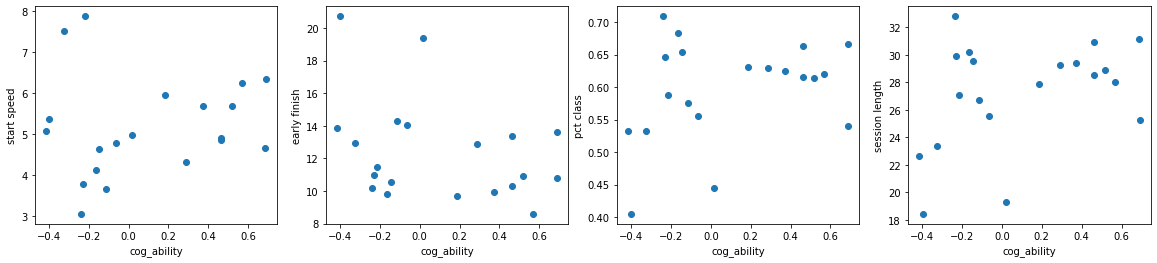

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = -0.006864173213498399	 pval = 0.9770870394770995
INFO:analytics.session:early finish Correlation with cog_ability: 
R = -0.04469479104213593	 pval = 0.8515792888539365
INFO:analytics.session:pct class Correlation with cog_ability: 
R = 0.11561876297451014	 pval = 0.6273906536031434
INFO:analytics.session:session length Correlation with cog_ability: 
R = 0.19706153462064688	 pval = 0.4049843832670601


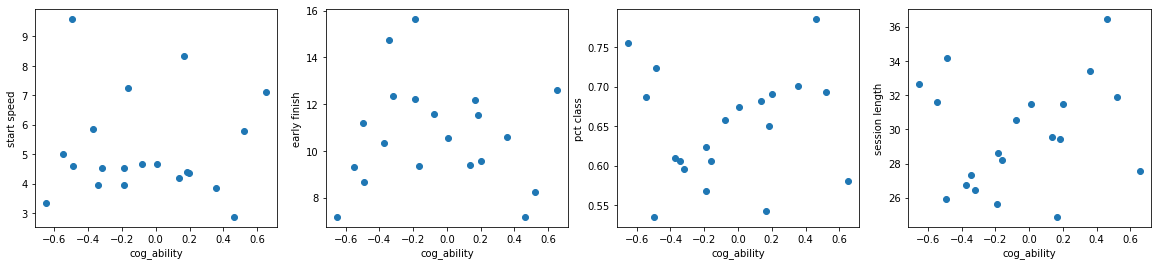

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:start speed Correlation with cog_ability: 
R = -0.07629461084868394	 pval = 0.7491984131279338
INFO:analytics.session:early finish Correlation with cog_ability: 
R = 0.2222830556952816	 pval = 0.34622872380471376
INFO:analytics.session:pct class Correlation with cog_ability: 
R = -0.16783593360576157	 pval = 0.4793816585396228
INFO:analytics.session:session length Correlation with cog_ability: 
R = -0.14900897491503867	 pval = 0.5306618024636719


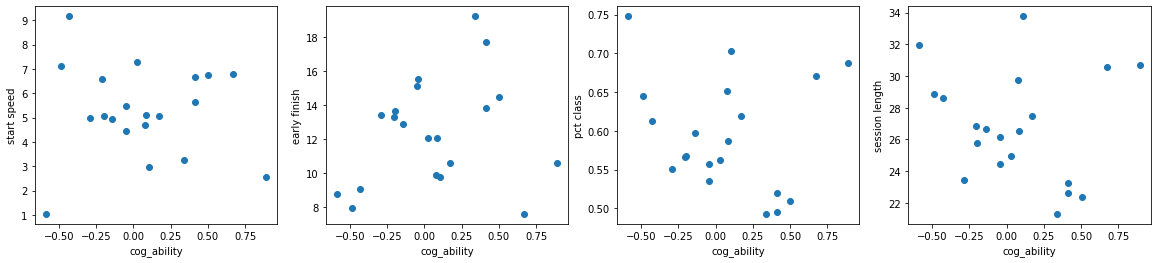

In [52]:

cols = ['start speed', 'early finish', 'pct class', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Work Rate

### Offtask

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.06195843070257738	 pval = 0.7952541036494791
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.2346523610485119	 pval = 0.31933660835157374
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.747702936270713	 pval = 0.00015071056338878734
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = 0.03954651922254181	 pval = 0.8685239156826317


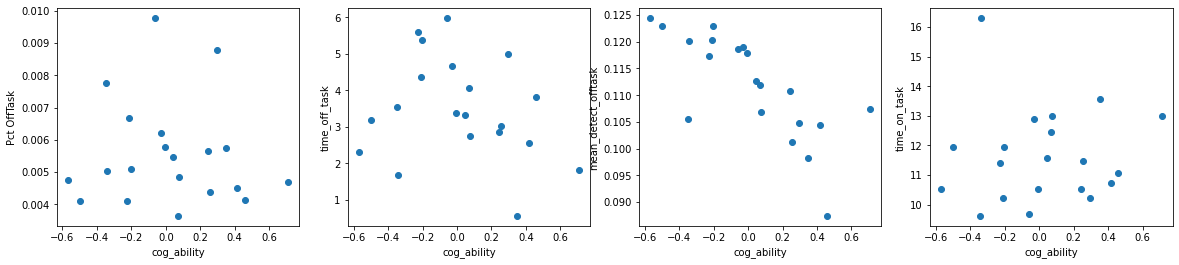

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.20665030161481485	 pval = 0.3820351232045499
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = 0.22635149989748948	 pval = 0.33724204190470336
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.16437522139658384	 pval = 0.4886180516072042
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = 0.16276947856546303	 pval = 0.49293321500879433


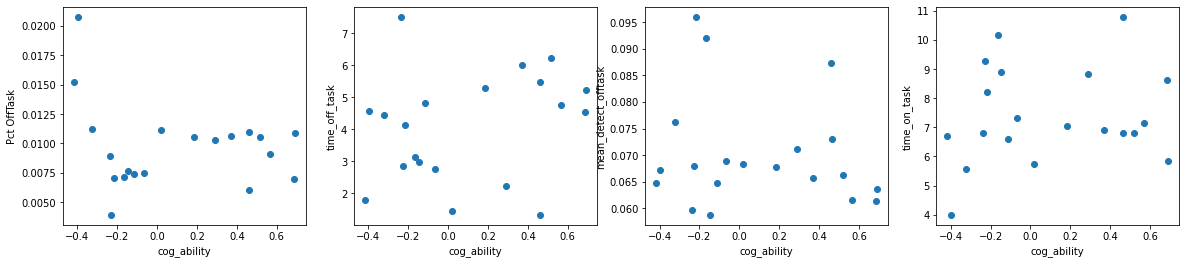

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = -0.11464519341995452	 pval = 0.6303117941988063
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.3948908689870707	 pval = 0.08486468425885378
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.5899422188075428	 pval = 0.006182133316511507
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = 0.18999342265887045	 pval = 0.42237120054333566


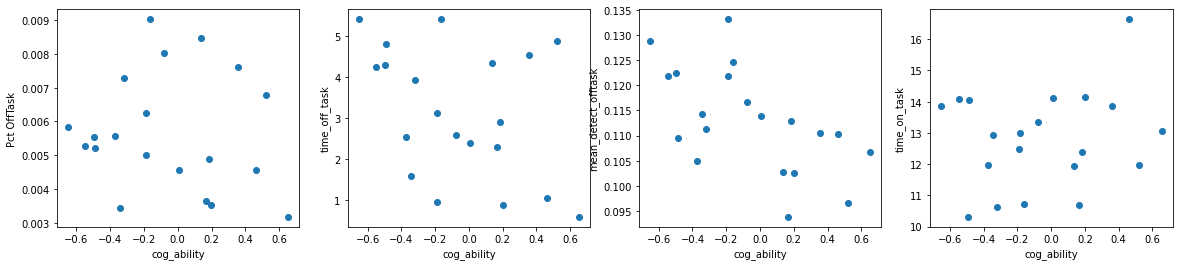

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct OffTask Correlation with cog_ability: 
R = 0.22952006837688363	 pval = 0.3303389674403763
INFO:analytics.session:time_off_task Correlation with cog_ability: 
R = -0.04571465505402252	 pval = 0.8482297693101225
INFO:analytics.session:mean_detect_offtask Correlation with cog_ability: 
R = -0.2336572789069347	 pval = 0.3214524902809561
INFO:analytics.session:time_on_task Correlation with cog_ability: 
R = -0.10269439023308419	 pval = 0.6665892237412161


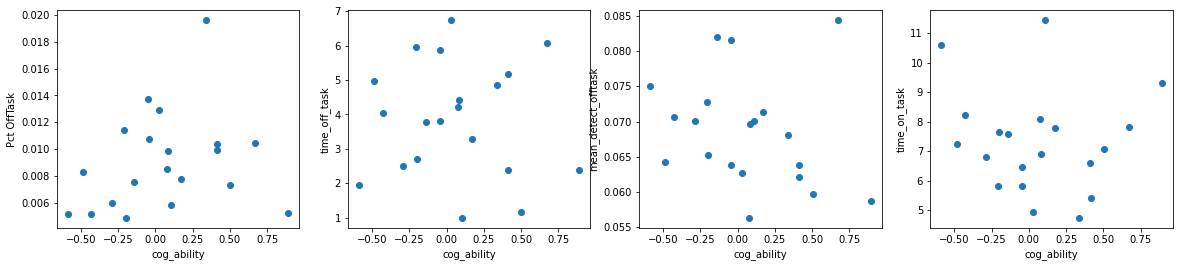

In [53]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'cog_ability'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Self-Efficacy

### Work Rate

### Offtask

INFO:analytics.session:************** Simple diligent students ******************
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = nan	 pval = nan


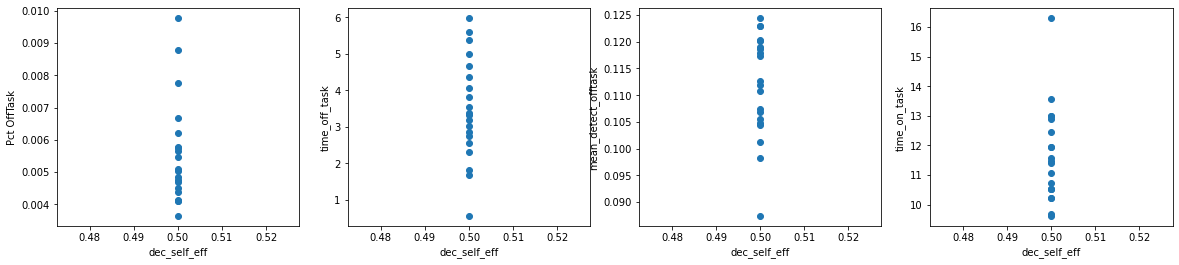

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = 0.7460496972797453	 pval = 0.00015877682866874537
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = 0.03345764406035197	 pval = 0.8886352893256728
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = -0.5960080047628687	 pval = 0.005549455559939099
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = -0.7529142585839028	 pval = 0.00012753941424697155


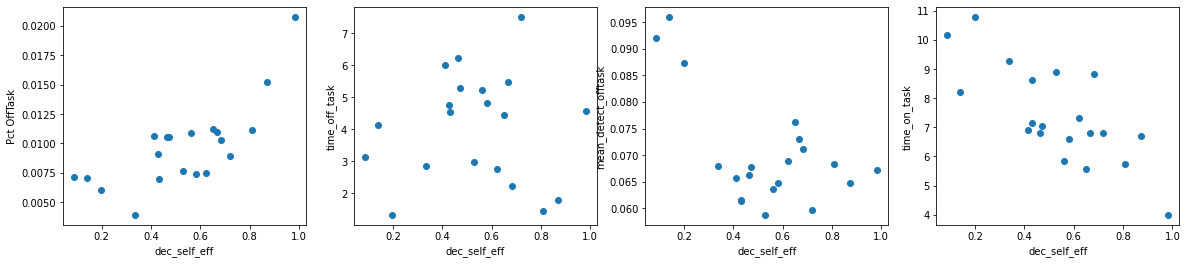

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = nan	 pval = nan


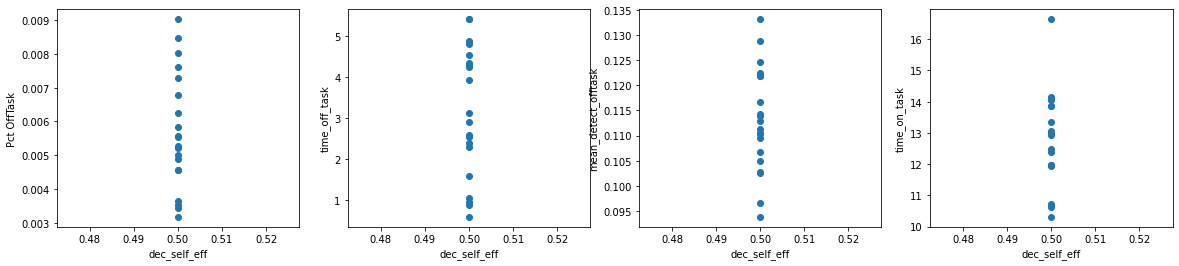

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct OffTask Correlation with dec_self_eff: 
R = 0.749188187624629	 pval = 0.00014376600354169903
INFO:analytics.session:time_off_task Correlation with dec_self_eff: 
R = 0.3127023327583149	 pval = 0.17948020462550474
INFO:analytics.session:mean_detect_offtask Correlation with dec_self_eff: 
R = -0.30266663880978123	 pval = 0.19460070523343265
INFO:analytics.session:time_on_task Correlation with dec_self_eff: 
R = -0.5664608309634694	 pval = 0.00921501053845373


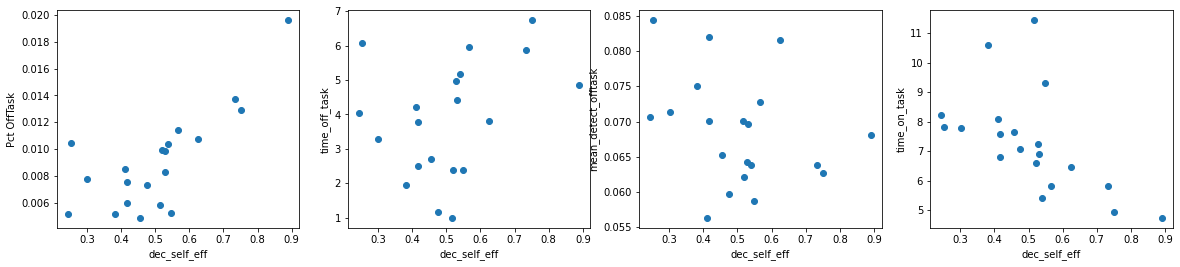

In [54]:

cols = ['Pct OffTask', 'time_off_task', 'mean_detect_offtask', 'time_on_task']

for i,desc in enumerate(batch_descs):
        sstats = stu_stats[desc]  
        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            xcol = 'dec_self_eff'
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Help-seeking

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = nan	 pval = nan


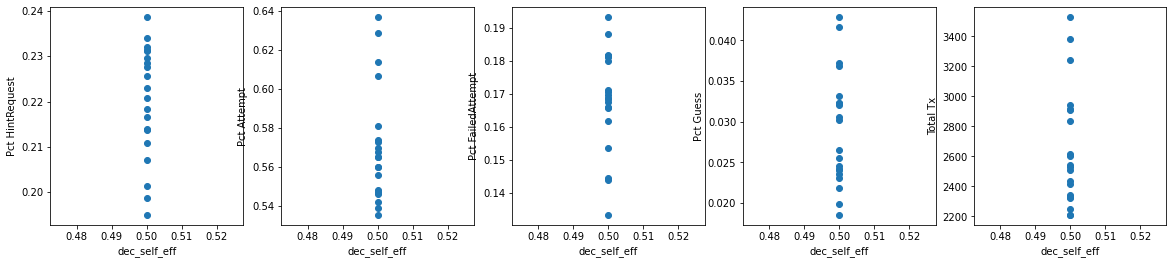

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = 0.569639238326421	 pval = 0.008744977421222001
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = -0.49877533581940864	 pval = 0.025181552425994857
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = -0.9151496771862673	 pval = 1.5862192266030412e-08
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = 0.7210536927517218	 pval = 0.00033407542906498057
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = -0.6244583883609431	 pval = 0.0032485190300190155


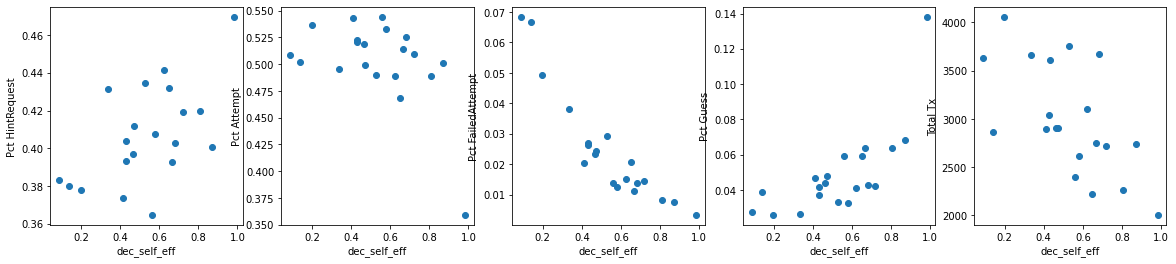

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = nan	 pval = nan


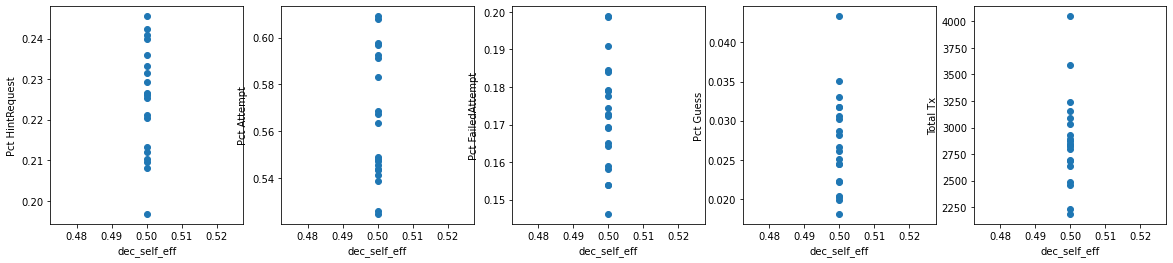

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Pct HintRequest Correlation with dec_self_eff: 
R = 0.18903308012389616	 pval = 0.4247639388066052
INFO:analytics.session:Pct Attempt Correlation with dec_self_eff: 
R = -0.5030358281555559	 pval = 0.023771218700049866
INFO:analytics.session:Pct FailedAttempt Correlation with dec_self_eff: 
R = -0.9108992702940676	 pval = 2.4239192183294278e-08
INFO:analytics.session:Pct Guess Correlation with dec_self_eff: 
R = 0.7582344802895095	 pval = 0.00010710596940650686
INFO:analytics.session:Total Tx Correlation with dec_self_eff: 
R = -0.5183505409334197	 pval = 0.019210026246622085


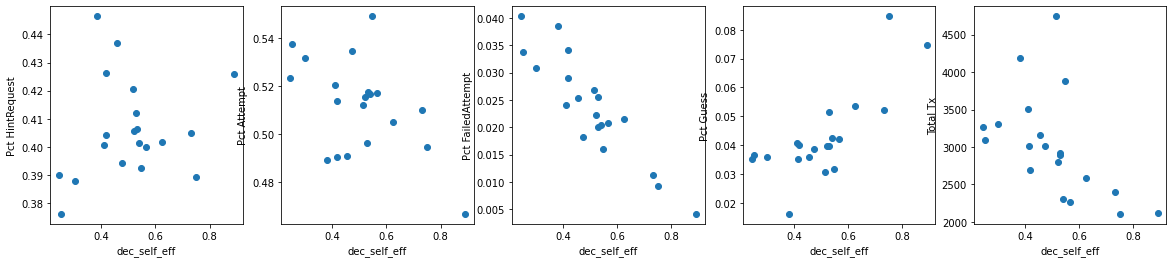

In [55]:

cols = ['Pct HintRequest', 'Pct Attempt', 'Pct FailedAttempt', 'Pct Guess', 'Total Tx']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

### Knowledge & Learning

INFO:analytics.session:************** Simple diligent students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = nan	 pval = nan


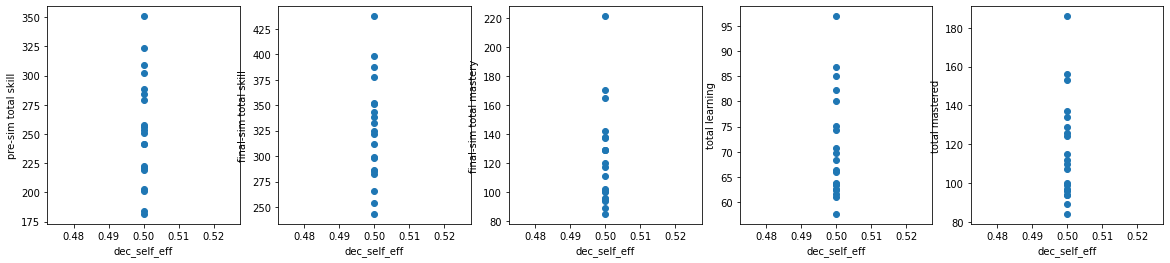

INFO:analytics.session:************** Self-Efficacy students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = -0.2718832479360659	 pval = 0.24620527229611505
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = -0.48104475682456627	 pval = 0.03177533318853695
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = -0.822107274725206	 pval = 8.710237250133339e-06
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = -0.8564353272951275	 pval = 1.4438924347181956e-06
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = -0.8574484437142293	 pval = 1.3599975392095851e-06


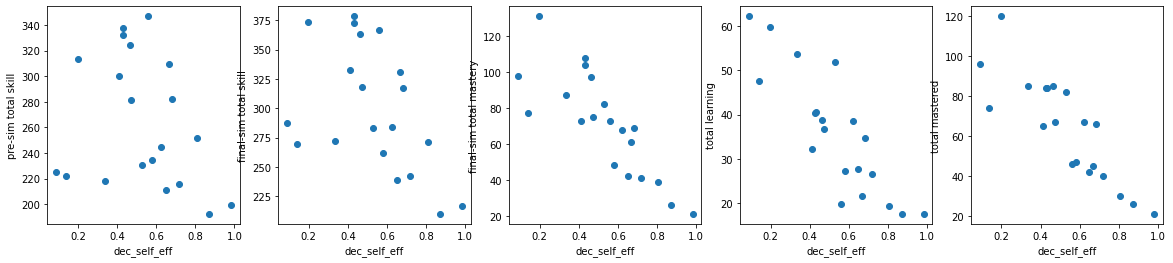

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = nan	 pval = nan
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = nan	 pval = nan


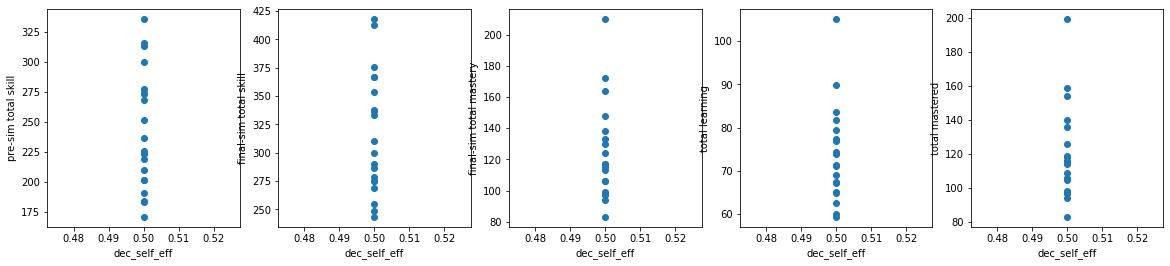

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:pre-sim total skill Correlation with dec_self_eff: 
R = 0.1208651896711478	 pval = 0.6117416620277515
INFO:analytics.session:final-sim total skill Correlation with dec_self_eff: 
R = -0.05477673739368912	 pval = 0.8185835036606247
INFO:analytics.session:final-sim total mastery Correlation with dec_self_eff: 
R = -0.5983059207480875	 pval = 0.0053241533606036475
INFO:analytics.session:total learning Correlation with dec_self_eff: 
R = -0.6918212686404069	 pval = 0.0007268066600041216
INFO:analytics.session:total mastered Correlation with dec_self_eff: 
R = -0.7120339150752643	 pval = 0.00042881610476710395


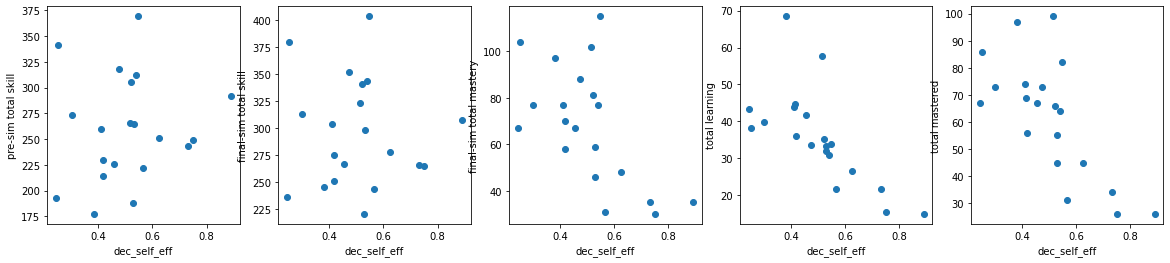

In [56]:

cols = ['pre-sim total skill', 'final-sim total skill', 'final-sim total mastery', 'total learning', 'total mastered']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    logger.info(f"************** {desc} ******************")
    plt.figure(figsize=(20,4))    
    for j, ycol in enumerate(cols):
        plt.subplot(1,len(cols), j+1)
        xcol = 'dec_self_eff'
        x = sstats[xcol]
        y = sstats[ycol]
        plt.scatter(x,y)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        corr, pval = pearsonr(x,y)
        logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


    plt.show()

## Intrinsic Interest

### Total Time

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with dec_interest: 
R = 0.3925433860192176	 pval = 0.08690150328312929
INFO:analytics.session:pct class Correlation with dec_interest: 
R = 0.44182921479314297	 pval = 0.0511266804652549
INFO:analytics.session:start speed Correlation with dec_interest: 
R = -0.7323679436616146	 pval = 0.00024095166222285247
INFO:analytics.session:early finish Correlation with dec_interest: 
R = 0.016905096894151133	 pval = 0.9436058175932214
INFO:analytics.session:session length Correlation with dec_interest: 
R = 0.3508904690555679	 pval = 0.12929268262201002


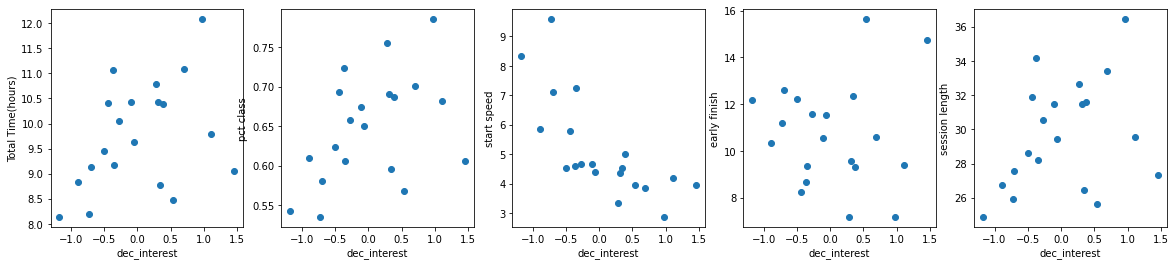

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with dec_interest: 
R = 0.3759025415540756	 pval = 0.10238586011774994
INFO:analytics.session:pct class Correlation with dec_interest: 
R = 0.4322047842113487	 pval = 0.05702402468162837
INFO:analytics.session:start speed Correlation with dec_interest: 
R = -0.9015362346464374	 pval = 5.7523020585419593e-08
INFO:analytics.session:early finish Correlation with dec_interest: 
R = -0.026886157458734263	 pval = 0.9104141176486299
INFO:analytics.session:session length Correlation with dec_interest: 
R = 0.3356719695331017	 pval = 0.14792884689810232


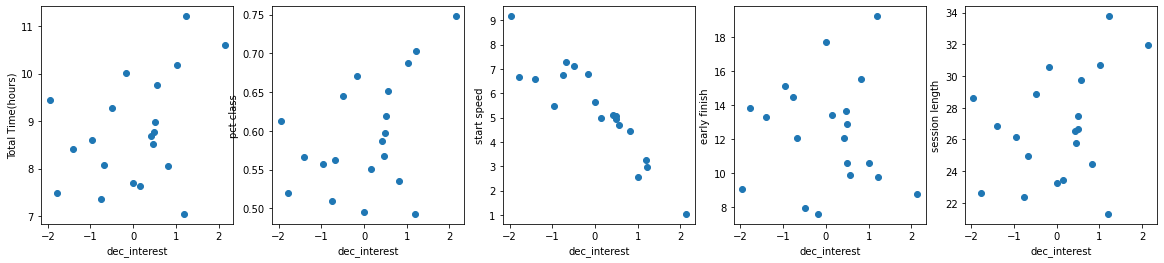

In [57]:

cols = ['Total Time(hours)', 'pct class', 'start speed', 'early finish', 'session length']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    xcol = 'dec_interest'
    if xcol in sstats.columns.tolist():
        logger.info(f"************** {desc} ******************")

        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)

            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Off-task & Guessing

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:OffTask Correlation with dec_interest: 
R = 0.32452249242719233	 pval = 0.16271966148637979
INFO:analytics.session:Pct OffTask Correlation with dec_interest: 
R = 0.12323016587446957	 pval = 0.6047395192481857
INFO:analytics.session:Pct Guess Correlation with dec_interest: 
R = -0.14867953801070743	 pval = 0.5315811533426322
INFO:analytics.session:mean_detect_offtask Correlation with dec_interest: 
R = 0.19291671980199035	 pval = 0.4151322781475055
INFO:analytics.session:mean_detect_guess Correlation with dec_interest: 
R = -0.17753885799378571	 pval = 0.45395733743126254


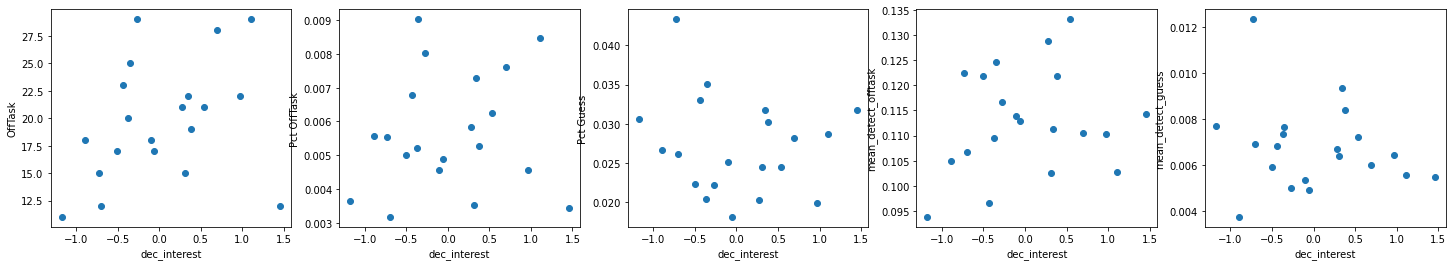

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:OffTask Correlation with dec_interest: 
R = 0.10636901203089219	 pval = 0.6553539398857646
INFO:analytics.session:Pct OffTask Correlation with dec_interest: 
R = -0.11964880654378496	 pval = 0.6153558061820176
INFO:analytics.session:Pct Guess Correlation with dec_interest: 
R = -0.2144018264052569	 pval = 0.36402885046028705
INFO:analytics.session:mean_detect_offtask Correlation with dec_interest: 
R = 0.20189471211413057	 pval = 0.3933243009750381
INFO:analytics.session:mean_detect_guess Correlation with dec_interest: 
R = -0.09900486117191294	 pval = 0.6779392715833942


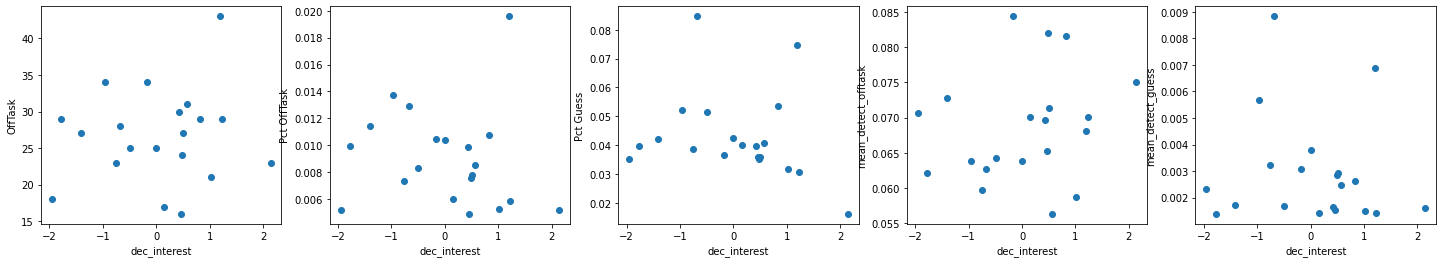

In [58]:

cols = ["OffTask", 'Pct OffTask', 'Pct Guess', 'mean_detect_offtask', 'mean_detect_guess']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    xcol = 'dec_interest'
    if xcol in sstats.columns.tolist():

        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(25,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)

            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()

### Time-on-task

INFO:analytics.session:************** Intrinsic Interest students ******************
INFO:analytics.session:Total Time(hours) Correlation with dec_interest: 
R = 0.3925433860192176	 pval = 0.08690150328312929
INFO:analytics.session:time_on_task Correlation with dec_interest: 
R = 0.4335603621018394	 pval = 0.05616354182464017
INFO:analytics.session:time_off_task Correlation with dec_interest: 
R = -0.09277428033632747	 pval = 0.6972577263765923


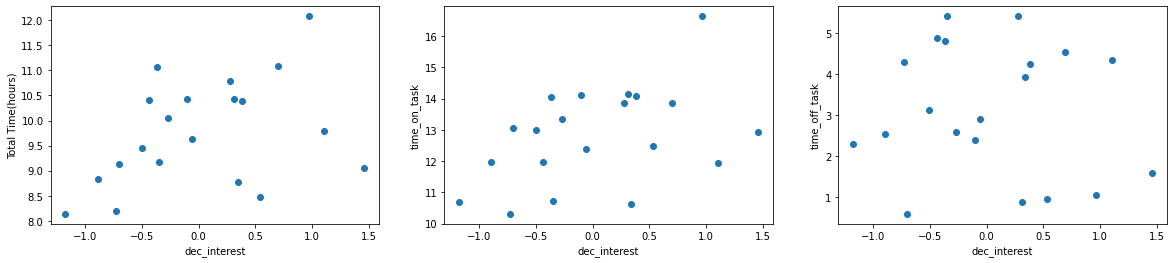

INFO:analytics.session:************** Combo students ******************
INFO:analytics.session:Total Time(hours) Correlation with dec_interest: 
R = 0.3759025415540756	 pval = 0.10238586011774994
INFO:analytics.session:time_on_task Correlation with dec_interest: 
R = 0.45494935572319406	 pval = 0.043852444951415485
INFO:analytics.session:time_off_task Correlation with dec_interest: 
R = -0.3568617528043045	 pval = 0.1224569528504416


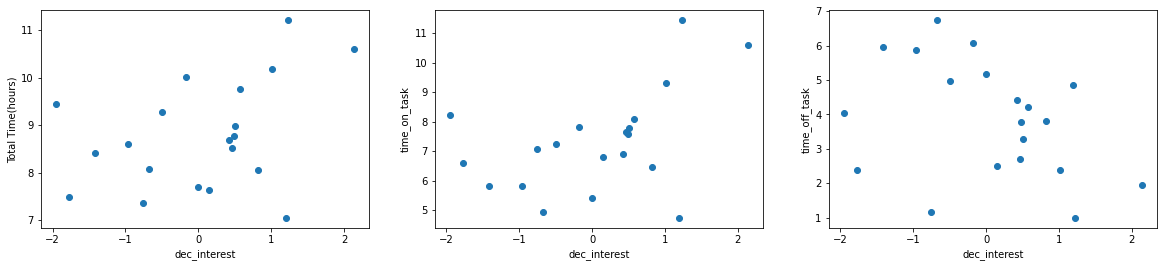

In [59]:

cols = ['Total Time(hours)', 'time_on_task', 'time_off_task']
for i,desc in enumerate(batch_descs):
    sstats = stu_stats[desc]
    xcol = 'dec_interest'
    if xcol in sstats.columns.tolist():

        logger.info(f"************** {desc} ******************")
        plt.figure(figsize=(20,4))    
        for j, ycol in enumerate(cols):
            plt.subplot(1,len(cols), j+1)
            x = sstats[xcol]
            y = sstats[ycol]
            plt.scatter(x,y)
            plt.xlabel(xcol)
            plt.ylabel(ycol)
            corr, pval = pearsonr(x,y)
            logger.info(f"{ycol} Correlation with {xcol}: \nR = {corr}\t pval = {pval}")


        plt.show()